### 2D Depth Resolution

/var/folders/2p/6sbgx0k17vd2r04z5581zh840000gn/T/ipykernel_64583/2297071638.py:139: UserWarning: Setting the 'color' property will override the edgecolor or facecolor properties.
  poly = plt.Polygon(corners, closed=True, color='#FF5252', alpha=0.5,


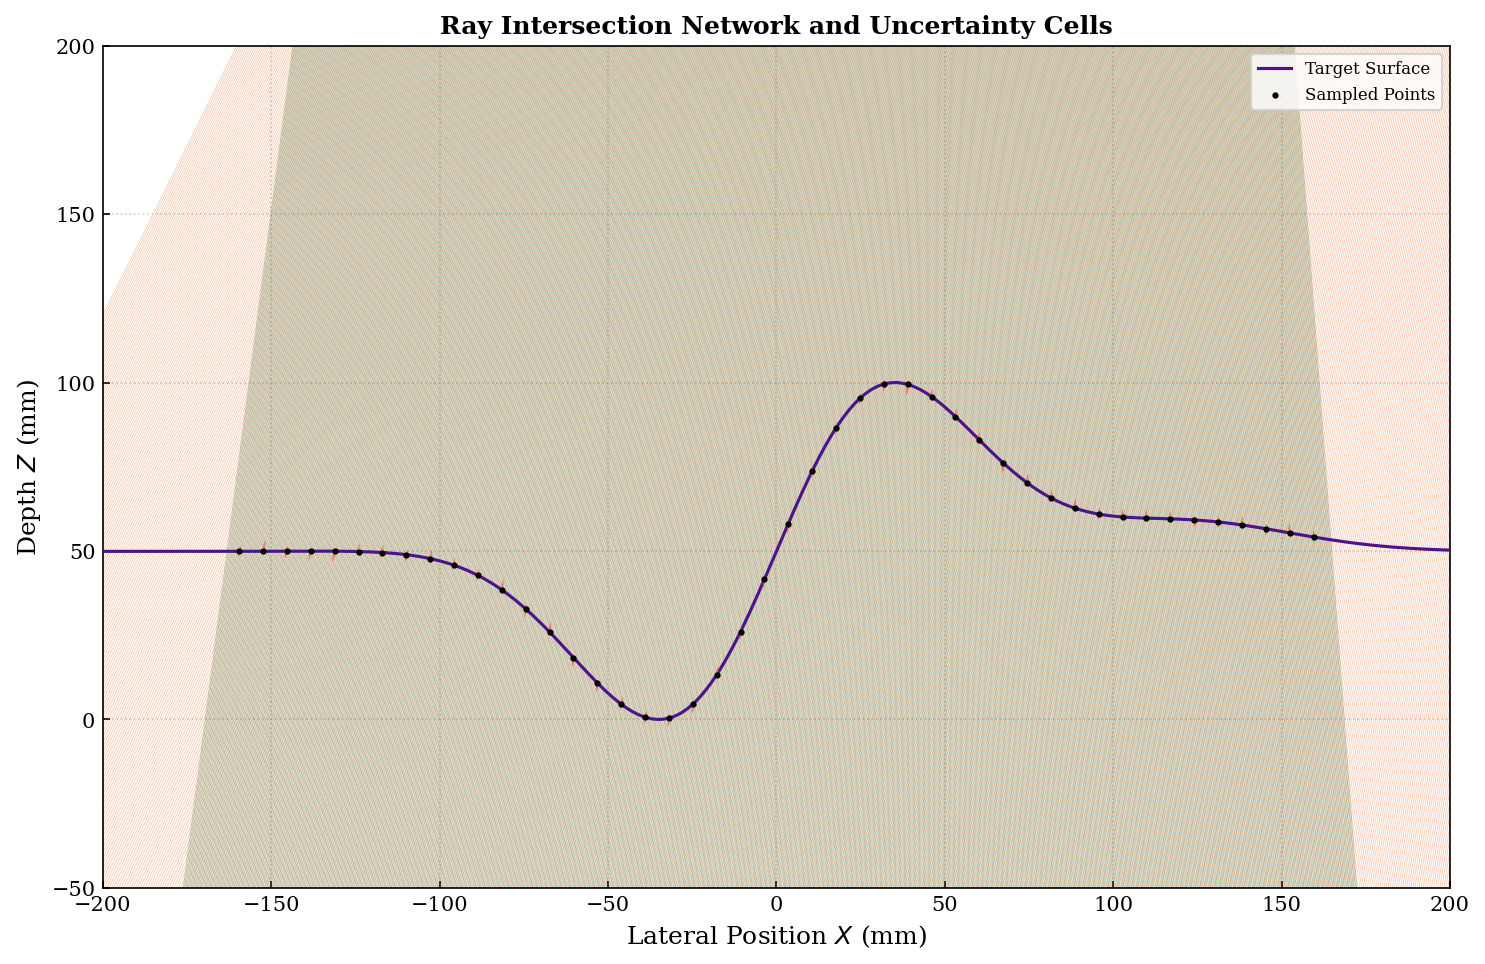

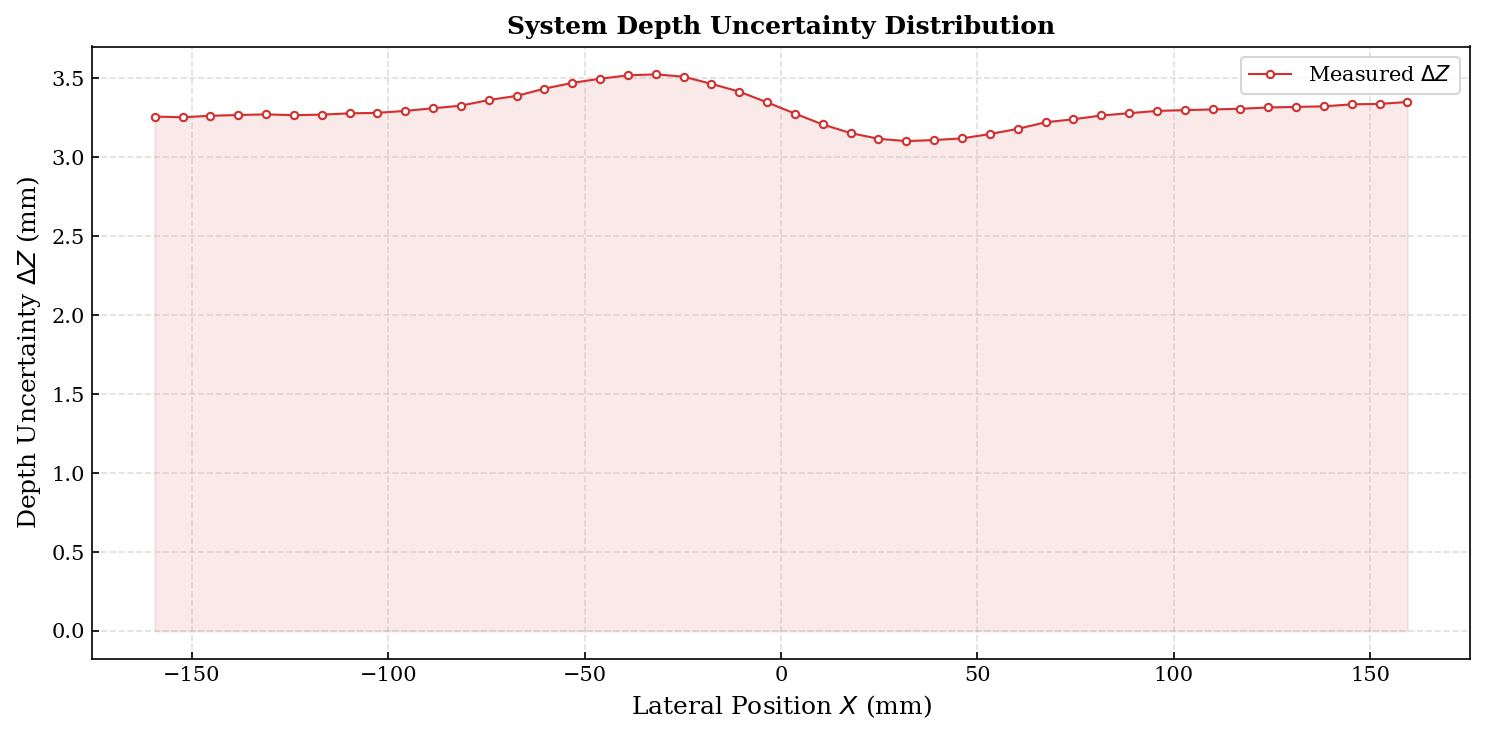

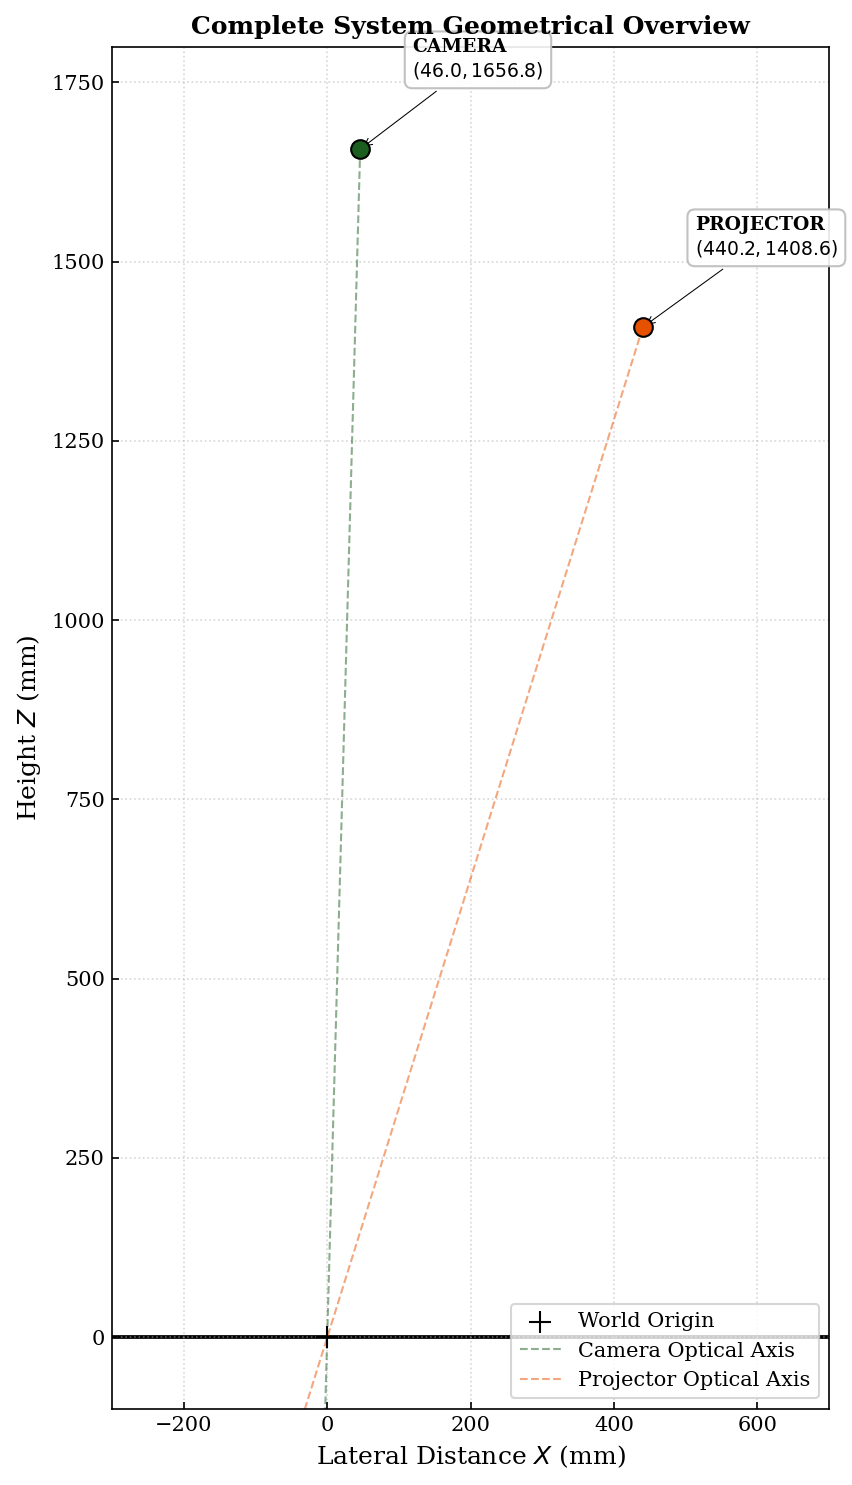

In [1]:
import matplotlib.pyplot as plt
import numpy as np

# Global plot parameters for academic-style visualization
plt.rcParams.update({
    "font.family": "serif",     
    "font.size": 10,            
    "axes.labelsize": 12,       
    "axes.titlesize": 12,       
    "xtick.direction": "in",    
    "ytick.direction": "in",    
    "lines.linewidth": 1.0,     
    "figure.dpi": 150          
})

# System parameters: Intrinsics and Extrinsics for Camera and Projector
systems = {
    "camera": {
        "focal_length": 4550.58,  # Focal length in pixels/mm
        "num_pixels": 928,        # Sensor resolution
        "pixel_pitch": 1,         # Distance between pixels
        "theta_deg": -1.59,       # Rotation angle in degrees
        "dx": 45.97,              # X-axis translation (mm)
        "dy": 1656.82,            # Y-axis translation (mm)
        "color": "#1B5E20"        # Dark Green
    },
    "projector": {
        "focal_length": 2405.99, 
        "num_pixels": 768, 
        "pixel_pitch": 1, 
        "theta_deg": -17.35,      
        "dx": 440.23,             
        "dy": 1408.60,            
        "color": "#E65100"        # Dark Orange
    }
}

def get_transform(theta_deg, dx, dy):
    """Generates a coordinate transformation function (Rotation + Translation)."""
    theta_rad = np.radians(theta_deg)
    # 2D Rotation Matrix
    R = np.array([
        [np.cos(theta_rad), -np.sin(theta_rad)],
        [np.sin(theta_rad),  np.cos(theta_rad)]
    ])
    def transform(x, y):
        # Apply P_world = R * P_local + T
        return R @ np.array([x, y]) + np.array([dx, dy])
    return transform

def find_ray_index_for_point(point, rays):
    """Finds the two adjacent rays that bound the target point using cross products."""
    for i in range(len(rays) - 1):
        (p1, d1) = rays[i]
        (p2, d2) = rays[i + 1]
        v1 = point - p1
        v2 = point - p2
        # Determine if point is between rays by checking the sign of cross products
        cross1 = d1[0] * v1[1] - d1[1] * v1[0]
        cross2 = d2[0] * v2[1] - d2[1] * v2[0]
        if cross1 * cross2 <= 0:
            return i, i + 1
    return None

def compute_intersection(p1, d1, p2, d2):
    """Computes the intersection of two lines using Least Squares for stability."""
    A = np.stack([d1, -d2], axis=1)
    b = p2 - p1
    try:
        t_vals = np.linalg.lstsq(A, b, rcond=None)[0]
        return p1 + t_vals[0] * d1
    except:
        return None

def compute_depth_difference(corners):
    """Calculates the maximum Z-axis uncertainty within an intersection cell."""
    z_values = [pt[1] for pt in corners] 
    return max(z_values) - min(z_values)

# --- Phase 1: Ray Generation ---
rays = {}
for name, params in systems.items():
    transform = get_transform(params["theta_deg"], params["dx"], params["dy"])
    origin = transform(0, 0) # Optical center
    rays[name] = []
    # Generate pixel positions on the sensor plane
    pixel_positions = [i * params["pixel_pitch"] for i in range(-params["num_pixels"]//2, params["num_pixels"]//2 + 1)]
    for p in pixel_positions:
        px, py = transform(p, params["focal_length"])
        ray_dir = origin - np.array([px, py]) 
        ray_dir /= np.linalg.norm(ray_dir) # Normalize vector
        rays[name].append((np.array([px, py]), ray_dir))

# --- Figure 1: Ray Network and Uncertainty Cells ---
fig1, ax1 = plt.subplots(figsize=(10, 8))

# Define target surface (Synthetic profile using Sinusoid + Gaussian)
x_high_res = np.linspace(-300, 300, 500)
raw_shape = (np.exp(-0.0003 * x_high_res**2) * np.sin(x_high_res/40)) + \
            (0.1 * np.exp(-0.0005 * (x_high_res - 120)**2))
y_min, y_max = np.min(raw_shape), np.max(raw_shape)
y_high_res = 100 * (raw_shape - y_min) / (y_max - y_min) 
ax1.plot(x_high_res, y_high_res, color='#4A148C', linewidth=1.5, label="Target Surface", zorder=5)

# Draw Rays
for i, (p1, d1) in enumerate(rays["camera"]):
    ax1.axline(p1, p1 + d1, color=systems["camera"]["color"], alpha=0.3, linewidth=0.4)
for j, (p2, d2) in enumerate(rays["projector"]):
    ax1.axline(p2, p2 + d2, color=systems["projector"]["color"], alpha=0.3, linewidth=0.4)

# Sample surface to compute local uncertainty cells
sample_points_x = np.linspace(-280, 280, 80)
sample_points_y = np.interp(sample_points_x, x_high_res, y_high_res)
sample_points = np.stack([sample_points_x, sample_points_y], axis=1)

delta_z_list, x_coords = [], []
actual_sampled_pts = []

for point in sample_points:
    cam_range = find_ray_index_for_point(point, rays["camera"])
    proj_range = find_ray_index_for_point(point, rays["projector"])
    
    if cam_range and proj_range:
        i1, i2 = cam_range
        j1, j2 = proj_range
        # Define the four vertices of the uncertainty diamond formed by ray intersection
        v_indices = [(i1, j1), (i1, j2), (i2, j2), (i2, j1)]
        corners = []
        for c_idx, p_idx in v_indices:
            pt = compute_intersection(rays["camera"][c_idx][0], rays["camera"][c_idx][1],
                                      rays["projector"][p_idx][0], rays["projector"][p_idx][1])
            if pt is not None: corners.append(pt)
        
        if len(corners) == 4:
            delta_z_list.append(compute_depth_difference(corners))
            x_coords.append(point[0])
            actual_sampled_pts.append(point)
            # Plot the uncertainty cell (Red polygon)
            poly = plt.Polygon(corners, closed=True, color='#FF5252', alpha=0.5, 
                               edgecolor='#D32F2F', linewidth=0.5, zorder=10)
            ax1.add_patch(poly)

# Formatting Figure 1
actual_sampled_pts = np.array(actual_sampled_pts)
if len(actual_sampled_pts) > 0:
    ax1.scatter(actual_sampled_pts[:, 0], actual_sampled_pts[:, 1], 
                color='black', s=4, marker='o', label="Sampled Points", zorder=12)

ax1.set_title("Ray Intersection Network and Uncertainty Cells", fontweight='bold')
ax1.set_xlabel(r"Lateral Position $X$ (mm)")
ax1.set_ylabel(r"Depth $Z$ (mm)")
ax1.set_xlim(-200, 200)
ax1.set_ylim(-50, 200)
ax1.set_aspect('equal')
ax1.grid(True, linestyle=':', alpha=0.6)
ax1.legend(loc='upper right', fontsize=8)

plt.tight_layout()
plt.show()

# --- Figure 2: Depth Uncertainty Plot ---
fig2, ax2 = plt.subplots(figsize=(10, 5))
ax2.plot(x_coords, delta_z_list, color='#D32F2F', marker='o', markersize=3.5, 
         markerfacecolor='white', label=r"Measured $\Delta Z$")
ax2.fill_between(x_coords, delta_z_list, color='#D32F2F', alpha=0.1)
ax2.set_title("System Depth Uncertainty Distribution", fontweight='bold')
ax2.set_xlabel(r"Lateral Position $X$ (mm)")
ax2.set_ylabel(r"Depth Uncertainty $\Delta Z$ (mm)")
ax2.grid(True, linestyle='--', alpha=0.4)
ax2.legend()
plt.tight_layout()
plt.show()

# --- Figure 3: System Overview ---
fig3, ax3 = plt.subplots(figsize=(8, 10))
ax3.scatter(0, 0, color='black', marker='+', s=120, label="World Origin", zorder=20)
for name, params in systems.items():
    transform = get_transform(params["theta_deg"], params["dx"], params["dy"])
    center_pos = np.array([params["dx"], params["dy"]]) 
    sensor_center = transform(0, params["focal_length"])
    # Plot optical axis
    axis_dir = (center_pos - sensor_center) / np.linalg.norm(center_pos - sensor_center)
    ax3.plot([center_pos[0], center_pos[0] + axis_dir[0]*2000], [center_pos[1], center_pos[1] + axis_dir[1]*2000], 
             color=params["color"], linestyle='--', alpha=0.5, label=f"{name.title()} Optical Axis")
    ax3.scatter(*center_pos, color=params["color"], s=80, edgecolors='black', zorder=10)
    # Coordinate labels
    ax3.annotate(f"{name.upper()}\n$({params['dx']:.1f}, {params['dy']:.1f})$", 
                 xy=(params["dx"], params["dy"]), xytext=(25, 35), textcoords='offset points', 
                 fontsize=9, fontweight='bold', arrowprops=dict(arrowstyle='->', lw=0.5),
                 bbox=dict(boxstyle='round,pad=0.4', facecolor='white', alpha=0.9, edgecolor='#BBBBBB'))

ax3.axhline(0, color='black', linewidth=1.8, zorder=1)
ax3.set_title("Complete System Geometrical Overview", fontweight='bold')
ax3.set_xlabel(r"Lateral Distance $X$ (mm)")
ax3.set_ylabel(r"Height $Z$ (mm)")
ax3.set_aspect('equal')
ax3.set_xlim(-300, 700)
ax3.set_ylim(-100, 1800)
ax3.grid(True, linestyle=':', alpha=0.5)
ax3.legend(loc='lower right')

plt.tight_layout()
plt.show()